In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf

#univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


# Obtain data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#1. Se importa el archivo de Excel.
drive.mount('/content/drive')
data = pd.read_excel("/content/drive/MyDrive/6. Bogota_Promedio_Dias_Act_VAR_1.xlsx",parse_dates=['myday'], index_col='myday')
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,pm25,tmp,radsolar,pressure,ws
myday,,,,,
2021-01-01,17.543228,15.250833,208.575000,563.722222,1.576515
2021-01-02,8.511421,14.372917,147.683333,563.458333,1.070076
2021-01-03,7.106322,14.819583,182.383333,563.208333,1.385552
2021-01-04,12.549272,14.013810,225.625000,562.611111,1.282413
2021-01-05,18.811511,13.699167,247.200000,562.583333,1.240530
...,...,...,...,...,...
2024-05-27,6.745105,15.842424,158.041667,564.625000,1.520833
2024-05-28,9.555421,16.062879,163.256944,564.808333,1.214583
2024-05-29,8.254429,15.395455,147.576389,564.891667,1.278750


In [ ]:
# Crear el primer nuevo DataFrame "amzn"
amzn = data[['pm25']]

In [ ]:
dt = pd.DataFrame(amzn)
dt

,pm25
myday,
2021-01-01,17.543228
2021-01-02,8.511421
2021-01-03,7.106322
2021-01-04,12.549272
2021-01-05,18.811511
...,...
2024-05-27,6.745105
2024-05-28,9.555421
2024-05-29,8.254429


In [ ]:
data_variables = data[['tmp', 'radsolar', 'pressure', 'ws']]
data_variables

,tmp,radsolar,pressure,ws
myday,,,,
2021-01-01,15.250833,208.575000,563.722222,1.576515
2021-01-02,14.372917,147.683333,563.458333,1.070076
2021-01-03,14.819583,182.383333,563.208333,1.385552
2021-01-04,14.013810,225.625000,562.611111,1.282413
2021-01-05,13.699167,247.200000,562.583333,1.240530
...,...,...,...,...
2024-05-27,15.842424,158.041667,564.625000,1.520833
2024-05-28,16.062879,163.256944,564.808333,1.214583
2024-05-29,15.395455,147.576389,564.891667,1.278750


# Plot the series

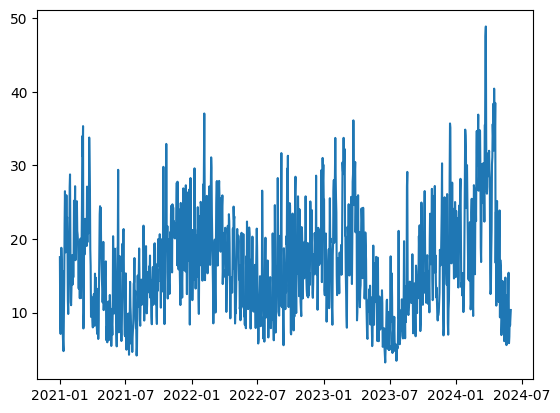

In [ ]:
plt.plot(dt['pm25'])

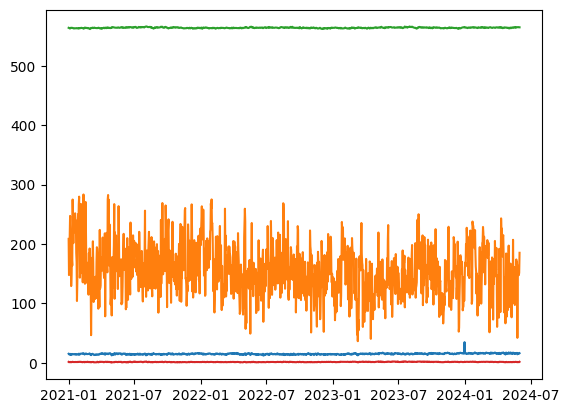

In [ ]:
plt.plot(data_variables[['tmp', 'radsolar', 'pressure', 'ws']])

# Preprocess the data

In [ ]:
dataindex = pd.to_datetime(dt.index)
dataindex

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-25',
               '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31'],
              dtype='datetime64[ns]', name='myday', length=1247, freq=None)

### Outcome variable

In [ ]:
input_data = data_variables.to_numpy().reshape((len(data_variables),len(data_variables.columns)))
input_data

array([[ 15.25083333, 208.575     , 563.72222222,   1.57651515],
       [ 14.37291667, 147.68333333, 563.45833333,   1.07007576],
       [ 14.81958333, 182.38333333, 563.20833333,   1.38555195],
       ...,
       [ 15.39545455, 147.57638889, 564.89166667,   1.27875   ],
       [ 15.54734848, 151.59722222, 564.58333333,   1.19916667],
       [ 16.17727273, 185.16224747, 564.54166667,   1.70458333]])

### Predict variables

In [ ]:
input_data = data_variables.to_numpy().reshape((len(data_variables),len(data_variables.columns)))
input_data

array([[ 15.25083333, 208.575     , 563.72222222,   1.57651515],
       [ 14.37291667, 147.68333333, 563.45833333,   1.07007576],
       [ 14.81958333, 182.38333333, 563.20833333,   1.38555195],
       ...,
       [ 15.39545455, 147.57638889, 564.89166667,   1.27875   ],
       [ 15.54734848, 151.59722222, 564.58333333,   1.19916667],
       [ 16.17727273, 185.16224747, 564.54166667,   1.70458333]])

# Train and test data; data definition

In [ ]:
split_percent = 0.90
split = int(split_percent*len(output_data))
n_back = 10

date_train = dataindex[:split]
date_test = dataindex[split:]

train_generator = TimeseriesGenerator(input_data[:split], output_data[:split], length=n_back, batch_size=25)
test_generator = TimeseriesGenerator(input_data[split:], output_data[split:], length=n_back, batch_size=1)

In [ ]:
print(len(input_data[:split]))
print(len(input_data[split:]))
print(len(input_data))

1122
125
1247


In [ ]:
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))

Samples: 45
Samples: 115


# Train the model

In [ ]:
#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(100, activation='relu', input_shape=(n_back, len(data_variables.columns)))
)

model.add(Dense(len(data_variables.columns)))
model.compile(optimizer='adam', loss='mse')

num_epochs = 50
model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

# Forecast in the test data

In [ ]:
#Predicción en el set de prueba:
prediction = model.predict(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
output_data = output_data.reshape((-1))

prediction_amzn = []
for i in range(len(prediction)):
    prediction_amzn.append(prediction[i][0])

115/115 [==============================] - 2s 8ms/step


In [ ]:
#Podemos primeramente graficar las secciones: la serie de entrenamiento, la predicción en la sección de prueba y la sección de prueba.
trace1 = go.Scatter(
    x = date_train, y = output_data[:split],
    mode = 'lines', name = 'Data'
)
trace2 = go.Scatter(
    x = date_test[n_back:], y = prediction_amzn,
    mode = 'lines', name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test, y = output_data[split:],
    mode='lines', name = 'Ground Truth'
)
layout = go.Layout(
    title = "Pm2.5",
    xaxis = {'title':"Date"},
    yaxis = {'title':"µg/m3"}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

# Error obtained in the test data

In [ ]:
#Evaluar el rendimiento del modelo
test_loss = model.evaluate(test_generator)
print('Test loss:', test_loss)

115/115 [==============================] - 2s 7ms/step - loss: 119.0231
Test loss: 119.02311706542969


# Forecast the future data

In [ ]:
#Hacer predicciones para el futuro
steps = 20
# Initialize the forecast list to store predictions
forecast = []

for i in range(steps):
    row_data = []

    for j in range(n_back):
        if i-j-1<0:
            row_data.append(input_data[i-j-1])
        else:
            row_data.append(forecast[i-j-1])

    predicted_value = model.predict(np.array(row_data).reshape(-1, n_back, len(data_variables.columns)))
    forecast.append(predicted_value[0])

forecast

1/1 [==============================] - 0s 34ms/step


[array([15.43888 , 15.828295, 15.975461, 15.482892], dtype=float32),
 array([14.329903, 15.931569, 14.823344, 18.006577], dtype=float32),
 array([13.334422, 16.80258 , 11.806501, 18.120281], dtype=float32),
 array([ 8.66796  , 12.320676 ,  4.8796983, 23.792677 ], dtype=float32),
 array([ 7.318844 , 14.132275 ,  2.4572272, 21.354181 ], dtype=float32),
 array([  7.543548 ,   6.6172624, -11.977375 ,  18.010714 ], dtype=float32),
 array([ 13.361775 ,  -2.0657887, -19.299852 ,   4.2662945], dtype=float32),
 array([ 11.964647  ,  -5.0418825 , -19.674936  ,   0.11990061],
       dtype=float32),
 array([  7.12832   , -10.549307  , -17.252144  ,   0.23684533],
       dtype=float32),
 array([ -2.3105621, -11.556032 , -27.74534  ,  -9.781347 ], dtype=float32),
 array([-0.35716945, -0.31997555, -2.2077293 , -0.3545589 ], dtype=float32),
 array([-0.9825338 , -0.20442162, -1.8511508 , -0.9219698 ], dtype=float32),
 array([-1.2849977 , -0.07741439, -1.5274093 , -1.5027125 ], dtype=float32),
 array([-